In [1]:
#import the libraries
import pandas as pd
from sqlalchemy import create_engine
import getpass
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#create connection with MySQL
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


### From MySql

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

### Data Cleaning

2. Read the data into a Pandas dataframe.

In [3]:
query = 'SELECT * FROM sakila.film_rental'
data = pd.read_sql_query(query, engine)
data

,film_id,n_rentals,category,rental_rate,replacement_cost,rating
0,1,23,Documentary,0.99,21,PG
1,2,6,Horror,4.99,13,G
2,3,12,Documentary,2.99,19,NC-17
3,4,22,Horror,2.99,27,G
4,5,11,Family,2.99,23,G
...,...,...,...,...,...,...
953,996,7,Documentary,0.99,10,G
954,997,6,Music,0.99,15,NC-17
955,998,8,Horror,0.99,11,NC-17
956,999,17,Children,2.99,29,R


3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           958 non-null    int64  
 1   n_rentals         958 non-null    int64  
 2   category          958 non-null    object 
 3   rental_rate       958 non-null    float64
 4   replacement_cost  958 non-null    int64  
 5   rating            958 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 45.0+ KB


In [5]:
#check NaN values
data.isnull().sum()

film_id             0
n_rentals           0
category            0
rental_rate         0
replacement_cost    0
rating              0
dtype: int64

In [6]:
#check values 
data['category'].value_counts()

Sports         73
Family         67
Foreign        67
Animation      64
Documentary    63
Action         61
Drama          61
New            60
Sci-Fi         59
Games          58
Children       58
Comedy         56
Classics       54
Horror         53
Travel         53
Music          51
Name: category, dtype: int64

In [7]:
data['rating'].value_counts()

PG-13    213
NC-17    202
R        189
PG       183
G        171
Name: rating, dtype: int64

In [8]:
#separate categorical and numerical columns
X_cat = data.select_dtypes('object')
X_num = data.select_dtypes('number')

In [9]:
#apply Hot Encoder on categorical columns
encoder = OneHotEncoder(drop ='first').fit(X_cat)
encoded = encoder.transform(X_cat).toarray()

4. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.

__NOTE:__ As 90% of films were rented in August, I decided to approve the films that were rented more than 5 times.

In [10]:
query = "SELECT * FROM sakila.rental_prediction"
data = pd.read_sql_query(query, engine)
data

,film_id,n_rentals,category,rental_rate,replacement_cost,rating,rented_last_month
0,1,23,Documentary,0.99,21,PG,Yes
1,2,6,Horror,4.99,13,G,No
2,3,12,Documentary,2.99,19,NC-17,Yes
3,4,22,Horror,2.99,27,G,Yes
4,5,11,Family,2.99,23,G,No
...,...,...,...,...,...,...,...
953,996,7,Documentary,0.99,10,G,No
954,997,6,Music,0.99,15,NC-17,No
955,998,8,Horror,0.99,11,NC-17,No
956,999,17,Children,2.99,29,R,Yes


In [11]:
data['rented_last_month'].value_counts()  #now, the values are balanced

Yes    516
No     442
Name: rented_last_month, dtype: int64

### Data Exploration 

In [12]:
#define the target and independent variables
y = data['rented_last_month']
X = np.concatenate((encoded, X_num), axis=1)

5. Create a logistic regression model to predict this variable from the cleaned data.

In [27]:
#apply train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100)

In [28]:
#and then Logistic regression
classification = LogisticRegression(random_state = 0, solver = 'lbfgs',
                  multi_class = 'ovr').fit(X_train, y_train)
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.8784722222222222

6. Evaluate the results.

In [29]:
#check values
pd.Series(predictions).value_counts()

Yes    166
No     122
dtype: int64

The accuracy of the model on test set is: 0.88 
[[107  20]
 [ 15 146]]
The Kappa of your model is: 0.75


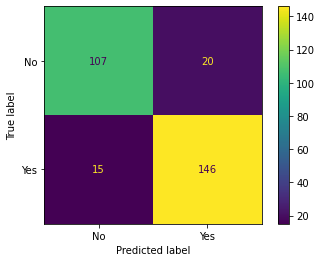

In [30]:
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))
plt.show() 